Run notebook 3 times for relu, sigmoid and tanh

# Environment Set-Up

In [1]:
import os
import pickle
import time
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go

import matplotlib.pyplot as plt

from lca.training import train_and_calculate_lca

%matplotlib inline

In [2]:
print(tf.__version__)
print(np.__version__)
print(plotly.__version__)

2.1.0
1.19.4
4.12.0


# Load MNIST

Source: https://www.tensorflow.org/tutorials/quickstart/beginner

Source: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

In [3]:
# Prepare the training dataset.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# training_size
training_size = x_train.shape[0]

print(x_train.shape)

(50000, 784)


# Specify Model

In [4]:
activation_label = 'tanh'

# architecture
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(100, activation="tanh", kernel_initializer='glorot_uniform')(inputs)
x2 = layers.Dense(50, activation="tanh", kernel_initializer='glorot_uniform')(x1)
outputs = layers.Dense(10, name="predictions", kernel_initializer='glorot_uniform')(x2)
model = keras.Model(inputs=inputs, outputs=outputs)
num_params = (784*100 + 100 + 100*50 + 50 + 50*10 + 10)
# loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

# Doesn't seem to work
# optimizer = tf.keras.optimizers.SGD(
#     learning_rate=0.01, momentum=.01,
#     name='SGD'
# )

# Training + Collect LCA

## Specify Training Parameters

In [5]:
# num epochs, paper says they train for 4 epochs and each epoch is 220 steps
num_epochs = 4
# batch_size
batch_size = training_size // 220
# batch_size = training_size // 880

print(batch_size)

227


## Training Loop + Calculate LCA Inputs

In [6]:
outputs = train_and_calculate_lca(model, num_params, loss_fn, optimizer, x_train, y_train, x_val, y_val,
                                 batch_size=batch_size, num_epochs=num_epochs)


Start of epoch 0
Training loss (for one batch) at step 0: 2.6691
Seen so far: 227 samples
Training loss (for one batch) at step 20: 1.0818
Seen so far: 4767 samples
Training loss (for one batch) at step 40: 0.7506
Seen so far: 9307 samples
Training loss (for one batch) at step 60: 0.6325
Seen so far: 13847 samples
Training loss (for one batch) at step 80: 0.6229
Seen so far: 18387 samples
Training loss (for one batch) at step 100: 0.5447
Seen so far: 22927 samples
Training loss (for one batch) at step 120: 0.4333
Seen so far: 27467 samples
Training loss (for one batch) at step 140: 0.5186
Seen so far: 32007 samples
Training loss (for one batch) at step 160: 0.5823
Seen so far: 36547 samples
Training loss (for one batch) at step 180: 0.4445
Seen so far: 41087 samples
Training loss (for one batch) at step 200: 0.4400
Seen so far: 45627 samples
Training loss (for one batch) at step 220: 0.3942
Seen so far: 50167 samples
Training acc over epoch: 0.7948
Validation acc: 0.8733
Time taken: 5

In [7]:
train_acc_list = outputs['train_acc']
val_acc_list = outputs['val_acc']
step_loss_list = outputs['train_loss']
step_lcas_over_time = outputs['lcas']

## Save LCAs (Optional)

In [8]:
# with open('../data/experiment_2/lcas_run_1.pickle', 'wb') as f:
#     pickle.dump(step_lcas_over_time, f)

# Evaluation

## Read LCAs (Optional)

In [9]:
# ## Save LCAs
# with open('../data/experiment_2/lcas_run_1.pickle', 'rb') as f:
#     step_lcas_over_time = pickle.load(f)

## Plot Train/Val  Accuracy and Loss

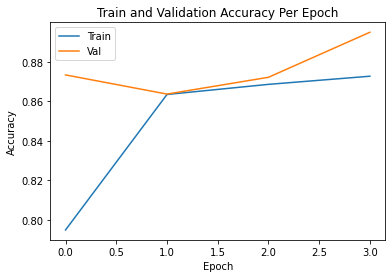

In [10]:
plt.plot(train_acc_list,label='Train')
plt.plot(val_acc_list,label='Val')
plt.legend()
plt.title("Train and Validation Accuracy Per Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.savefig(f'../data/experiment_2/{activation_label}/{activation_label}_train_val_acc.png', facecolor='white', bbox_inches='tight')

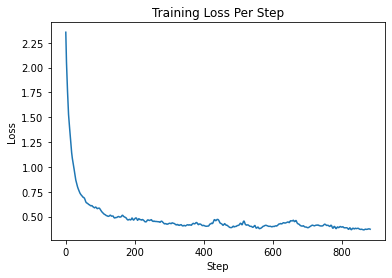

In [11]:
plt.plot(step_loss_list)
plt.title("Training Loss Per Step")
plt.ylabel("Loss")
plt.xlabel("Step")
plt.savefig(f'../data/experiment_2/{activation_label}/{activation_label}_train_loss.png', facecolor='white', bbox_inches='tight')

## Plot delta in training loss compared to Taylor approximation of delta on the step losses

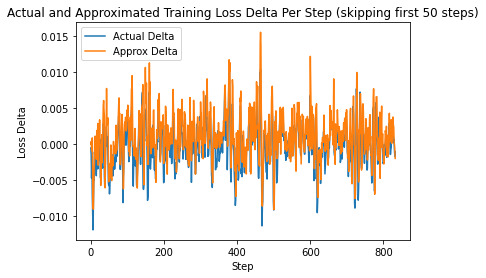

In [12]:
skip_step = 50
training_loss_delta = (np.array(step_loss_list)[1:] - np.array(step_loss_list)[:-1])[skip_step:]
training_loss_delta_approximation = step_lcas_over_time.sum(1)[skip_step:]
plt.plot(training_loss_delta,label='Actual Delta')
plt.plot(training_loss_delta_approximation,label='Approx Delta')
plt.legend()
plt.title("Actual and Approximated Training Loss Delta Per Step (skipping first 50 steps)")
plt.ylabel("Loss Delta")
plt.xlabel("Step")
plt.savefig(f'../data/experiment_2/{activation_label}/{activation_label}_train_delta.png', facecolor='white', bbox_inches='tight')

In [13]:
# approximation is highly correlated
np.corrcoef(training_loss_delta, training_loss_delta_approximation)
# screen shot

array([[1.        , 0.72583559],
       [0.72583559, 1.        ]])

## Categorize LCAs

In [14]:
def categorize_lca(lca, tol=.0, zero_cat=1):
    category = 0
    if lca == 0:
        category = zero_cat
    elif lca > 0:
        category = 2
    return category

pd.Series(step_lcas_over_time.flatten()).apply(lambda x :categorize_lca(x)).value_counts(normalize=True)

1    0.417326
0    0.313448
2    0.269226
dtype: float64

In [19]:
# tanh, relu, sigmoid
0.313448 / (0.313448 + 0.269226), .332 / (.332 + .285), .38 / (.38 + .30)

(0.5379474629037849, 0.5380875202593193, 0.5588235294117647)

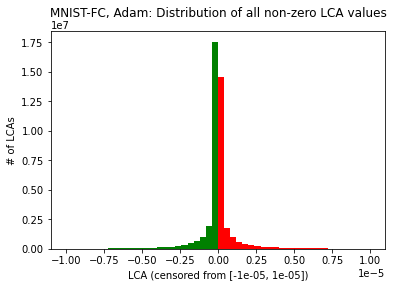

In [15]:
hist_range = np.quantile(step_lcas_over_time.flatten(),.01), np.quantile(step_lcas_over_time.flatten(),.99)
hist_range = [-1e-5, 1e-5]
plt.hist(step_lcas_over_time.flatten()[step_lcas_over_time.flatten() <0], bins=50, range=hist_range,color='green')
plt.hist(step_lcas_over_time.flatten()[step_lcas_over_time.flatten() >0], bins=50, range=hist_range,color='red')

plt.title('MNIST-FC, Adam: Distribution of all non-zero LCA values',y=1.04)
plt.xlabel(f'LCA (censored from {hist_range})')
plt.ylabel(f'# of LCAs')
plt.ylabel(f'# of LCAs')
plt.savefig(f'../data/experiment_2/{activation_label}/{activation_label}_lca_dist.png', facecolor='white', bbox_inches='tight')

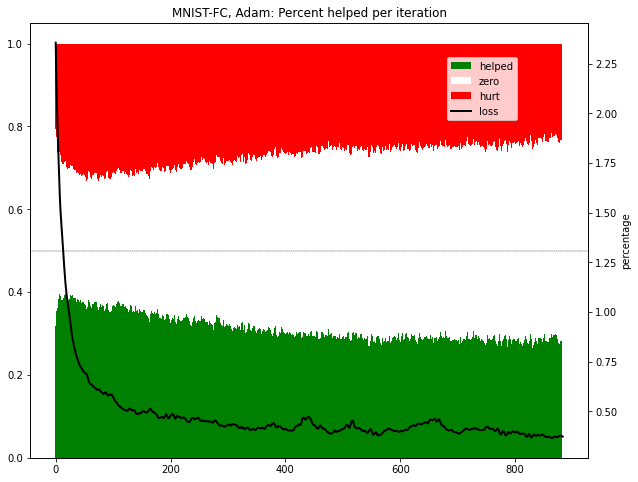

In [16]:
num_steps = step_lcas_over_time.shape[0]
num_weights = step_lcas_over_time.shape[1]
pct_positive_lcas_per_step = np.apply_along_axis(lambda x : (x>0).sum(), 1, step_lcas_over_time) / num_weights  
pct_zero_lcas_per_step = np.apply_along_axis(lambda x : (x==0).sum(), 1, step_lcas_over_time) / num_weights 
pct_negative_lcas_per_step = np.apply_along_axis(lambda x : (x<0).sum(), 1, step_lcas_over_time) / num_weights
ind = np.arange(num_steps)    # the x locations for the groups
width = 1

fig, ax1 = plt.subplots(figsize=(10,8))

p1 = ax1.bar(ind, pct_negative_lcas_per_step, width, bottom=0, color='green', label='helped')
p2 = ax1.bar(ind, pct_zero_lcas_per_step, width, bottom=pct_negative_lcas_per_step, color='white', label='zero')
p3 = ax1.bar(ind, pct_positive_lcas_per_step, width, bottom=pct_negative_lcas_per_step+pct_zero_lcas_per_step, color='red', label='hurt')
ax1.axhline(y=.5, xmin=0, xmax=num_steps, c='black',lw=.4,linestyle='--')

ax2 = ax1.twinx()
p0 = ax2.plot(step_loss_list, c='black',lw=2, label='loss')

plt.ylabel('percentage')
plt.title('MNIST-FC, Adam: Percent helped per iteration')
fig.legend(loc=(.7,.75))
plt.savefig(f'../data/experiment_2/{activation_label}/{activation_label}_lca_dist_over_time.png', facecolor='white', bbox_inches='tight')


## Interactive LCA over time (skip)

In [ ]:
from IPython.display import display
from ipywidgets import widgets

epoch_choice = widgets.IntSlider(value=0, min=0, max=len(step_lcas_over_time)-1)
layer_choice = widgets.Select(
    options=[0, 2, 4],
    value=0,
)

container = widgets.HBox(children=[epoch_choice, layer_choice])



layer_breaks = np.cumsum([78400,100,5000,50, 500,10])

layer_index_shape = dict(zip(
    layer_breaks,
    [layer.numpy().shape for layer in grads]
))

t = 0

def get_formatted_lcas_t(t, viz_layer=0):
    formatted_lcas_t = []
    lcas_t = step_lcas_over_time[t]
    layer_index_start = 0
    for layer_index in layer_breaks:
        layer_index_end = layer_index
        layer_lcas = lcas_t[layer_index_start:layer_index_end]
        layer_lcas = layer_lcas.reshape(layer_index_shape[layer_index])
        formatted_lcas_t.append(layer_lcas)
        layer_index_start = layer_index_end
    return formatted_lcas_t[viz_layer]

lcas_t_viz_layer = get_formatted_lcas_t(t)

fig = go.Figure(data=go.Heatmap(
                    z=lcas_t_viz_layer,
                    zmid=0,
#                     zmax=.001, zmin=-.001,
                    colorscale=['green','white','red'])
               )
interactive_figure = go.FigureWidget(fig)

In [ ]:
def response(change):
    lcas_t_viz_layer = get_formatted_lcas_t(epoch_choice.value, viz_layer=layer_choice.value)
    with interactive_figure.batch_update():
        interactive_figure.data[0].z = lcas_t_viz_layer
        
epoch_choice.observe(response, names="value")
layer_choice.observe(response, names="value")


In [ ]:
# weights for 1 seem to be highest at begining, compare LCA vs class accuracy over time

widgets.VBox([container,
              interactive_figure])